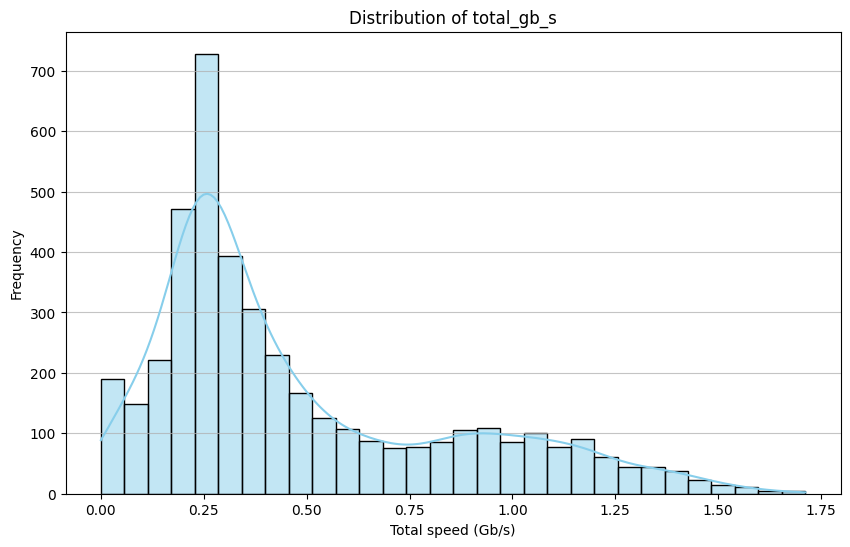

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

class NET_LSTM:
    
    @classmethod
    def load_and_preprocess_data(cls, file_path: str):
        """
        Load data from a csv file
        :param file_path: path to the csv file
        :return: a pandas dataframe
        """
        df = pd.read_csv(file_path)
        # Clean column names
        df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
        # Convert to datetime
        df['time'] = pd.to_datetime(df['time'])
        # Convert b/s to Gb/s for relevant columns
        df['download_gb_s'] = df['download_b/s'] / (10**9)
        df['total_gb_s'] = df['total_b/s'] / (10**9)
        return df

    @staticmethod
    def plot_distribution(df: pd.DataFrame, column: str, xlabel: str = 'Total speed (Gb/s)'):
        """
        Plot a histogram of the specified column.
        :param df: a pandas dataframe
        :param column: the column to plot
        :return: None
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(
            df[column],
            bins=30,
            kde=True, 
            color='skyblue',
            edgecolor='black'
        )
        plt.title(f'Distribution of {column}')
        plt.xlabel(xlabel)
        plt.ylabel('Frequency')
        plt.grid(axis='y', alpha=0.75)
        plt.show()

    @staticmethod
    def scale_data(df: pd.DataFrame, columns: list):
        """
        Scale the specified columns of the dataframe
        """
        scaler = MinMaxScaler(feature_range=(0, 1))
        df_scaled = df.copy()
        df_scaled[columns] = scaler.fit_transform(df[columns])
        return df_scaled, scaler
    
    @staticmethod
    def create_sequences(df: pd.DataFrame, n_steps: int):
        """
        Create sequences
        :param df: a pandas dataframe
        :param n_steps: the number of steps
        :return: a tuple of numpy arrays
        """
        X, y = [], []
        for i in range(len(df) - n_steps):
            sequence = df[i:i + n_steps]
            target = df[i + n_steps]
            X.append(sequence)
            y.append(target)
        return np.array(X), np.array(y)
    
    @staticmethod
    def create_sequences_with_timestamps(df: pd.DataFrame, n_steps: int, target_column: str):
        X, y, timestamps = [], [], []
        for i in range(n_steps, len(df)):
            X.append(df.iloc[i-n_steps:i][['download_gb_s', 'total_gb_s']].values)
            y.append(df.iloc[i][target_column])
            timestamps.append(df.iloc[i]['time'])  # Store the timestamp
        return np.array(X), np.array(y), np.array(timestamps)

# Load and preprocess data
file_path = './outup/usage_over_time.csv'
df = NET_LSTM.load_and_preprocess_data(file_path)

# Scale the data
columns_to_scale = ['download_gb_s', 'total_gb_s']
df_scaled, scaler = NET_LSTM.scale_data(df, columns_to_scale)  # Scale the data

# Visualize the distribution of the total speed (Gb/s)
NET_LSTM.plot_distribution(df, 'total_gb_s')  # Plot histogram

In [2]:
df.index = df['time']

time_series = df.index # Extract time series

In [3]:
required_cols = ['download_gb_s', 'total_gb_s']
df = df[required_cols]
df.head()

,download_gb_s,total_gb_s
time,,
2022-02-01 00:00:00+00:00,0.000000,0.000000
2022-02-02 18:00:00+00:00,0.000000,0.000000
2022-02-02 22:00:00+00:00,0.215997,0.433595
2022-02-03 02:00:00+00:00,0.104037,0.208081
2022-02-03 06:00:00+00:00,0.168858,0.340569


In [4]:
df.isna().sum()
df = df.ffill() 

In [5]:
n_steps = 18  # Number of time steps based on 3 days
# Create sequences (Divide the data into input and target)
X, y, timestamps = NET_LSTM.create_sequences_with_timestamps(df_scaled, n_steps, 'total_gb_s')

train_size = int(len(X) * 0.7)  # 70% train, 20% validation, 10% test
val_size = int(len(X) * 0.2)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]
timestamps_test = timestamps[train_size + val_size:] # Store the timestamps for the test set


In [6]:
n_features = X_train.shape[2]  # Number of features


In [7]:
# Build the model
model = Sequential([
    Input(shape=(n_steps, n_features)),
    LSTM(100, activation='relu', return_sequences=True),
    Dropout(0.2),
    LSTM(50, activation='relu'),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71,451 (279.11 KB)

 Trainable params: 71,451 (279.11 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
## Define callbacks

# Early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    mode='min',
    restore_best_weights=True
)

# Model checkpoint
model_checkpoint = ModelCheckpoint(
    'best_model1.keras',
    monitor='val_loss',
    save_best_only=True,
    # save_weights_only=False,
    # mode='min'
)

In [9]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0515 - val_loss: 0.0588
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0371 - val_loss: 0.0565
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0362 - val_loss: 0.0559
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0366 - val_loss: 0.0527
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0334 - val_loss: 0.0479
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0319 - val_loss: 0.0427
Epoch 7/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0305 - val_loss: 0.0398
Epoch 8/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0281 - val_loss: 0.0376
Epoch 9/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0257 - val_loss: 0.0339
Epoch 10/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0233 - val_loss: 0.0315
Epoch 11/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0211 - val_loss: 0.0240
Epoch 12/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0

In [10]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0028 
Test Loss: 0.0024516426492482424


In [11]:
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


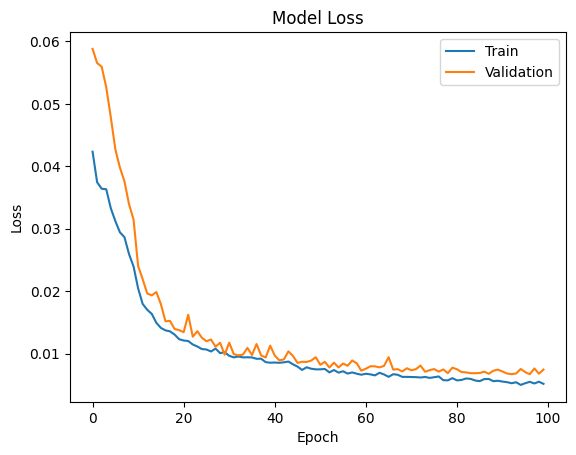

In [12]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [13]:
# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mae) # Correct RMSE calculation

In [14]:
print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)


Mean Absolute Error 0.03054083622496663
Mean Squared Error 0.0025263160495150286
Root Mean Squared Error 0.17475936663013697


ValueError: '---' is not a valid value for ls; supported values are '-', '--', '-.', ':', 'None', ' ', '', 'solid', 'dashed', 'dashdot', 'dotted'

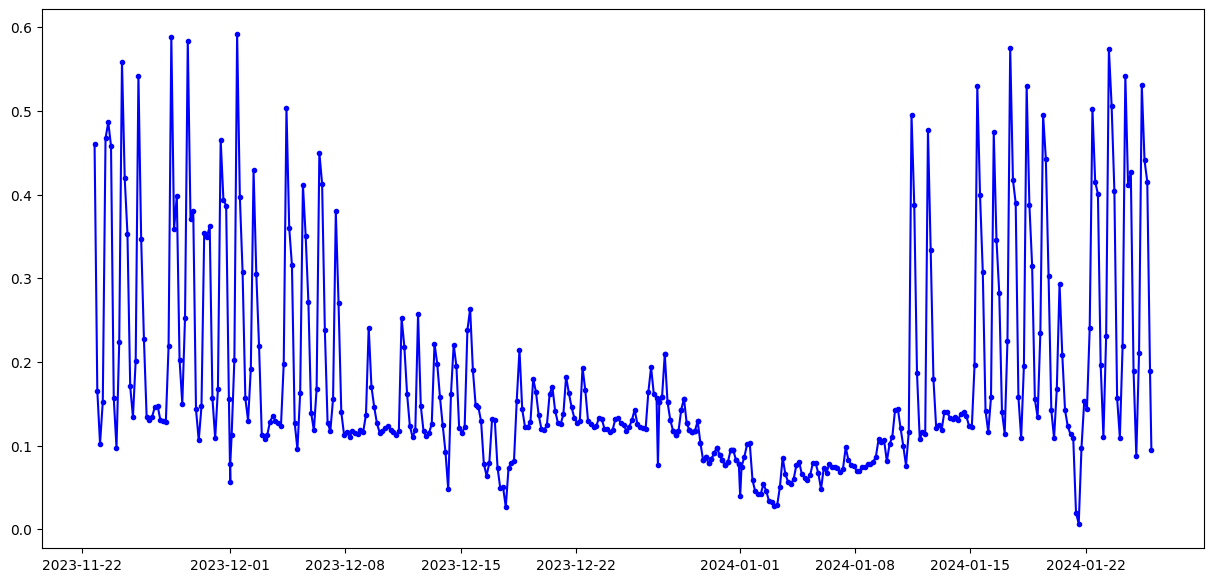

In [15]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(15, 7))
plt.plot(timestamps_test, y_test, label='Real', color='blue', marker='.')
plt.plot(timestamps_test, predictions.flatten(), label='Predicted', color='red', linestyle='---', marker='.')
plt.plot.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

AttributeError: 'function' object has no attribute 'title'

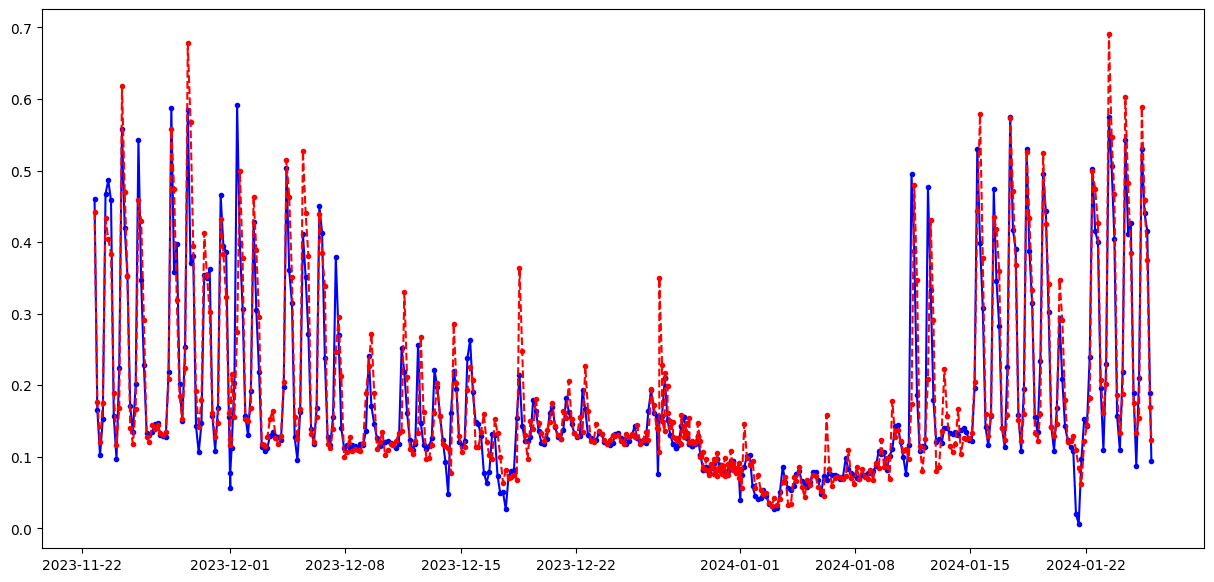

In [16]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(15, 7))
plt.plot(timestamps_test, y_test, label='Real', color='blue', marker='.')
plt.plot(timestamps_test, predictions.flatten(), label='Predicted', color='red', linestyle='--', marker='.')
plt.plot.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

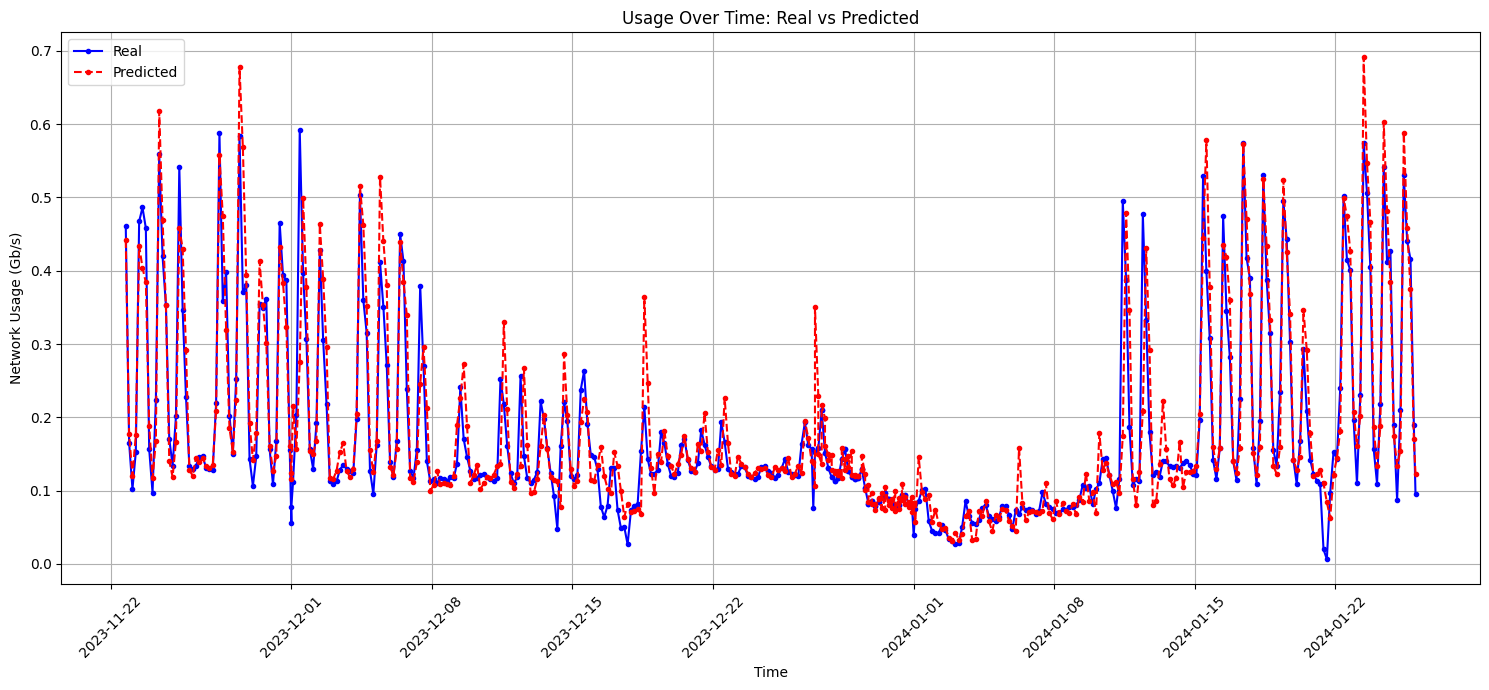

In [17]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(15, 7))
plt.plot(timestamps_test, y_test, label='Real', color='blue', marker='.')
plt.plot(timestamps_test, predictions.flatten(), label='Predicted', color='red', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

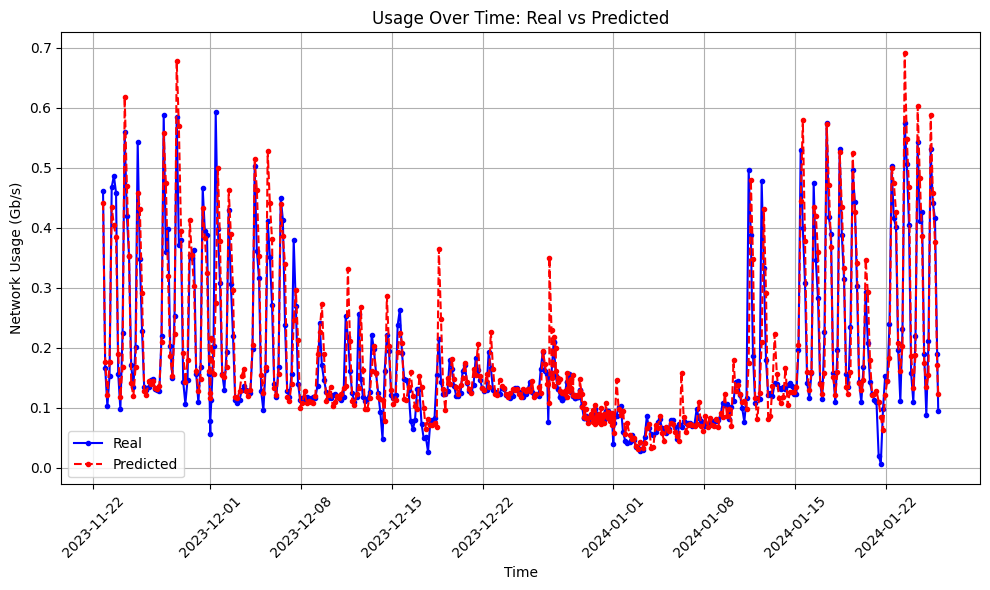

In [18]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test, y_test, label='Real', color='blue', marker='.')
plt.plot(timestamps_test, predictions.flatten(), label='Predicted', color='red', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

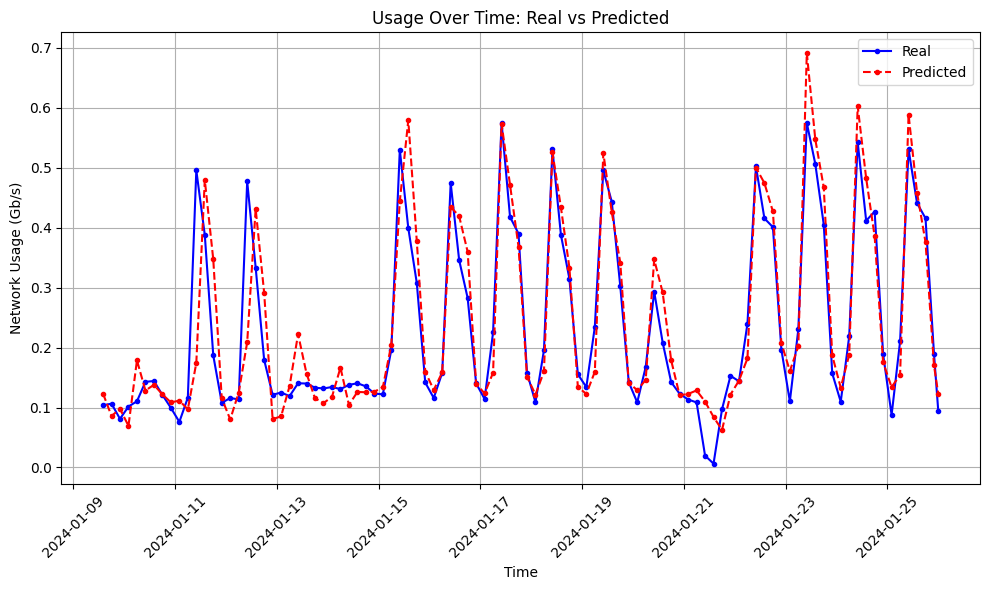

In [19]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', color='blue', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted', color='red', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

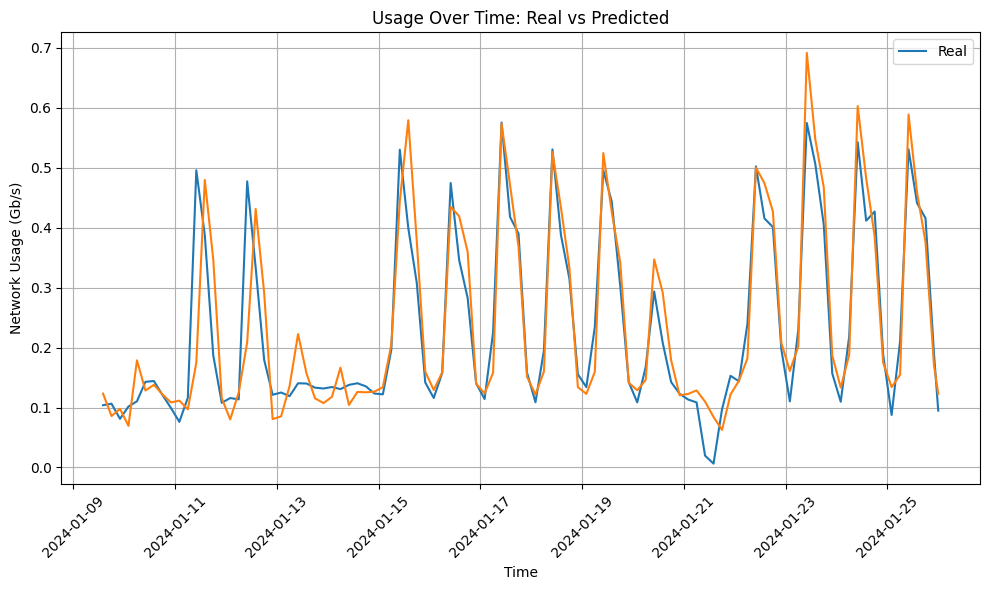

In [20]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real')
plt.plot(timestamps_test[-100:], predictions[-100:])
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

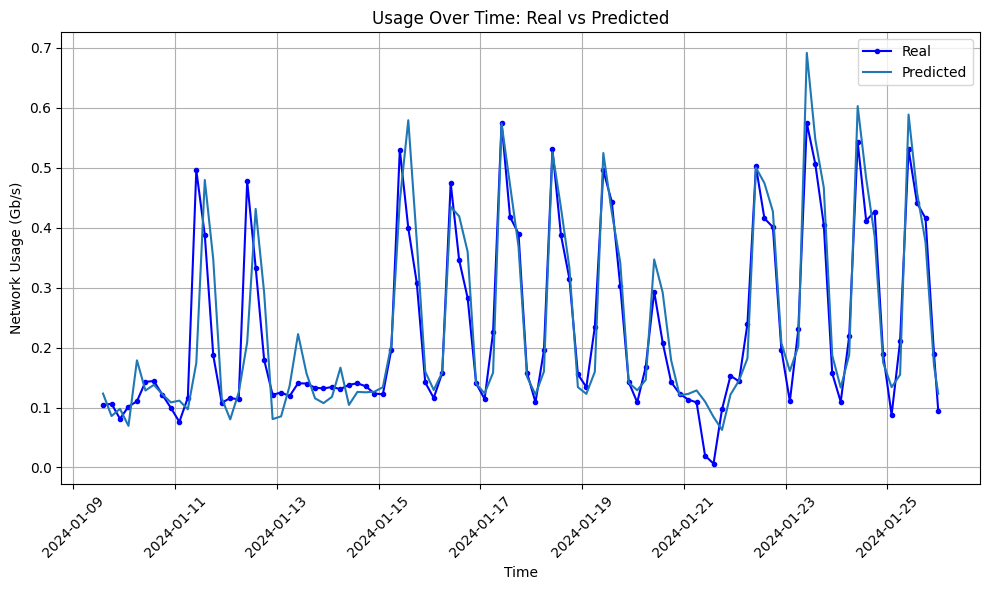

In [21]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', color='blue', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

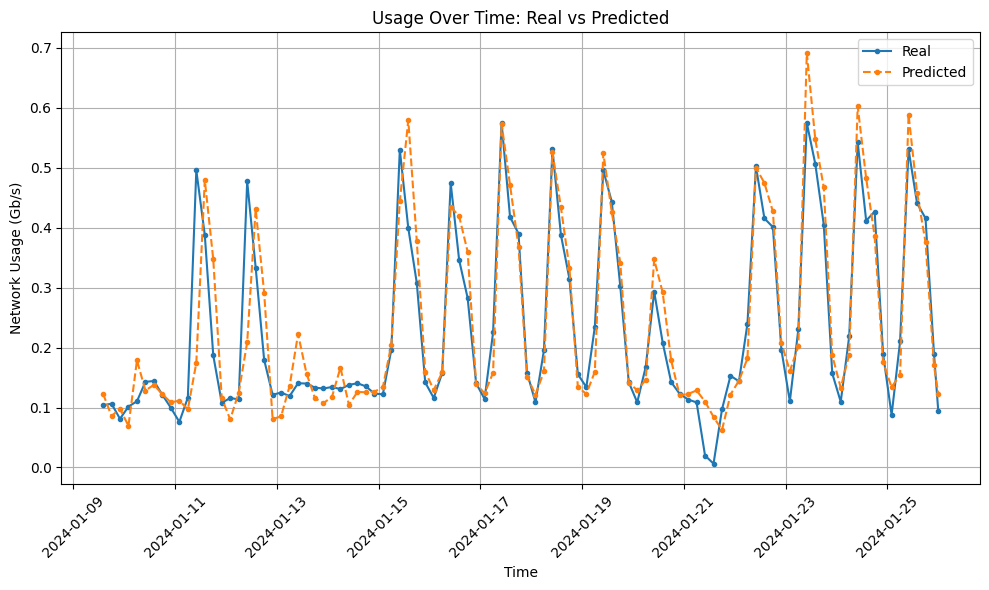

In [22]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

In [23]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,355 (837.33 KB)

 Trainable params: 71,451 (279.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,904 (558.22 KB)

In [24]:
# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mae) # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

Mean Absolute Error 0.03054083622496663
Mean Squared Error 0.0025263160495150286
Root Mean Squared Error 0.17475936663013697


In [25]:
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0070
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0052 - val_loss: 0.0067
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0051 - val_loss: 0.0077
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0054 - val_loss: 0.0068
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0070
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0046 - val_loss: 0.0074
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_loss: 0.0068
Epoch 9/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0065
Epoch 10/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0049 - val_loss: 0.0068
Epoch 11/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0047 - val_loss: 0.0067
Epoch 12/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0053 - val_lo

In [26]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0027 
Test Loss: 0.0024110395461320877


In [27]:
predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [28]:
# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mae) # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

Mean Absolute Error 0.031262304183088896
Mean Squared Error 0.0025330574431890497
Root Mean Squared Error 0.17681149335687682


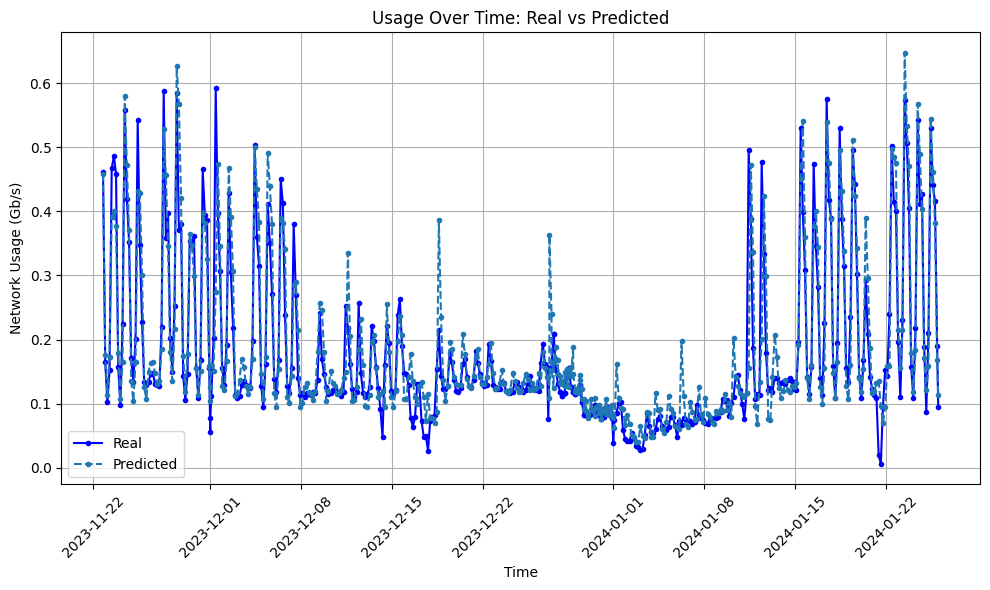

In [29]:
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test, y_test, label='Real', color='blue', marker='.')
plt.plot(timestamps_test, predictions.flatten(), label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

In [30]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,355 (837.33 KB)

 Trainable params: 71,451 (279.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,904 (558.22 KB)

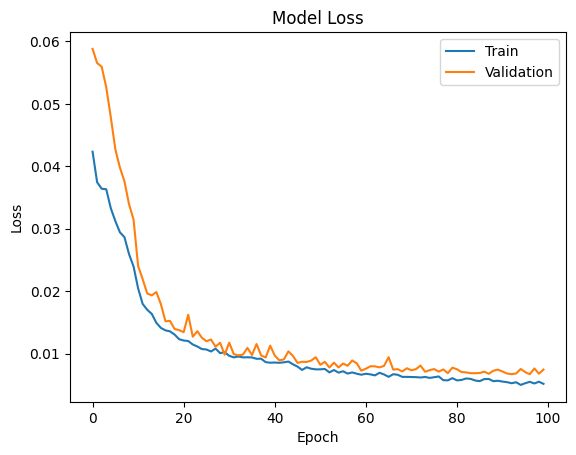

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()




In [32]:
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0048 - val_loss: 0.0067
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0069
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 0.0072
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0064
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0070
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0067
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 11/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0069
Epoch 12/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0043 - val_lo

In [33]:
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0068
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0066
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0042 - val_loss: 0.0069
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0040 - val_loss: 0.0069
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0042 - val_loss: 0.0070
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0070
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0068
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0068
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 0.0068
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0045 - val_loss: 0.0068


In [34]:
history_1 = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stopping, model_checkpoint],
    verbose=1
)

Epoch 1/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0071
Epoch 2/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0066
Epoch 3/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0047 - val_loss: 0.0073
Epoch 4/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0044 - val_loss: 0.0069
Epoch 5/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0072
Epoch 6/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0043 - val_loss: 0.0070
Epoch 7/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0052 - val_loss: 0.0073
Epoch 8/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0074
Epoch 9/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0046 - val_loss: 0.0065
Epoch 10/20
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0048 - val_loss: 0.0065


In [35]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 18, 100)        │        41,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 18, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 214,355 (837.33 KB)

 Trainable params: 71,451 (279.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 142,904 (558.22 KB)

In [36]:
test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

predictions = model.predict(X_test)

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0025 
Test Loss: 0.0023824197705835104
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


In [37]:
# Calculate and pritn error metrics
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mae) # Correct RMSE calculation

print("Mean Absolute Error", mae)
print("Mean Squared Error", mse)
print("Root Mean Squared Error", rmse)

Mean Absolute Error 0.030953165464074357
Mean Squared Error 0.0024732234697940063
Root Mean Squared Error 0.1759351171997062


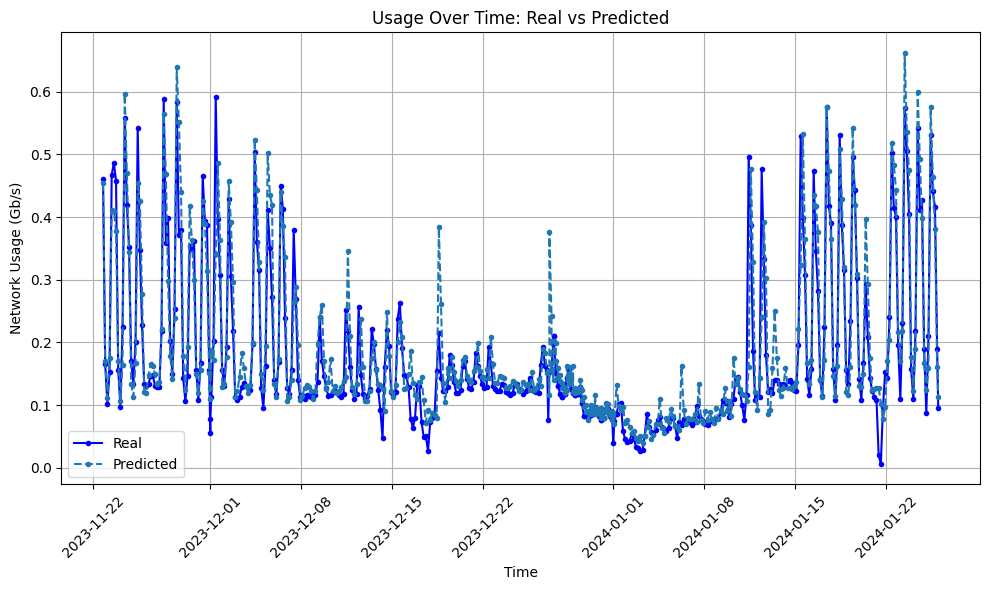

In [38]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test, y_test, label='Real', color='blue', marker='.')
plt.plot(timestamps_test, predictions.flatten(), label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

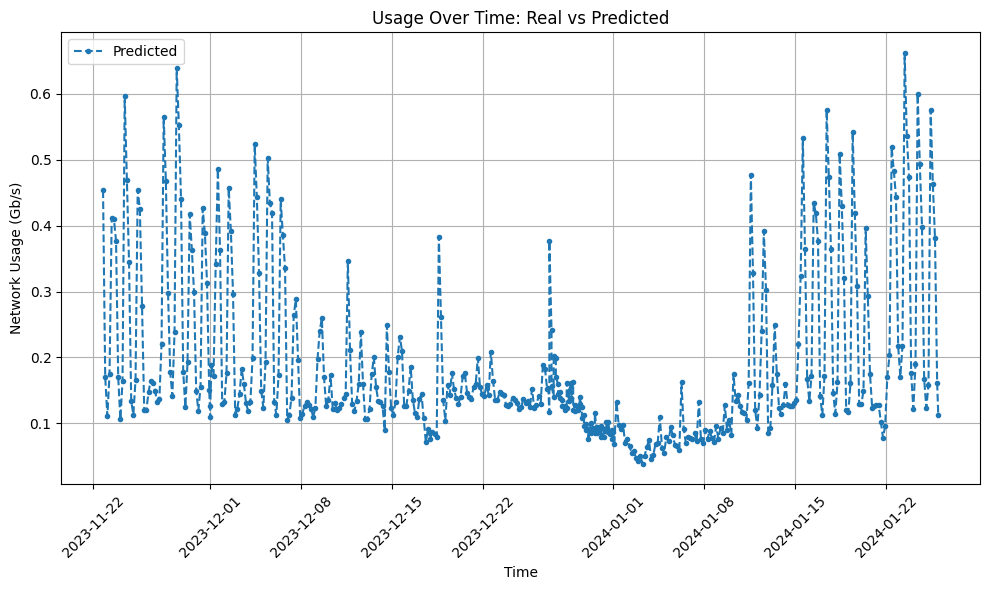

In [39]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
# plt.plot(timestamps_test, y_test, label='Real', color='blue', marker='.')
plt.plot(timestamps_test, predictions.flatten(), label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

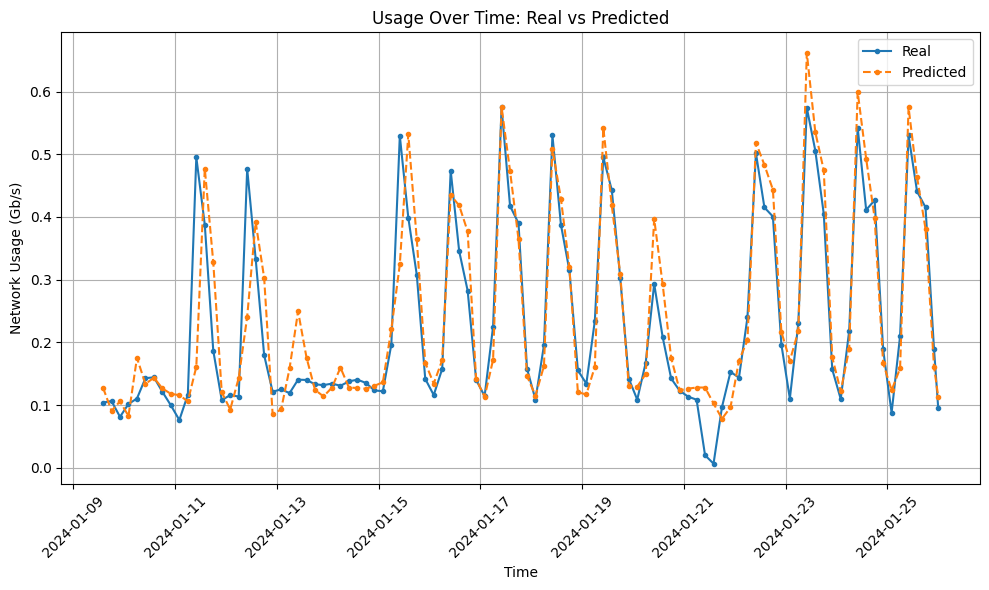

In [40]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

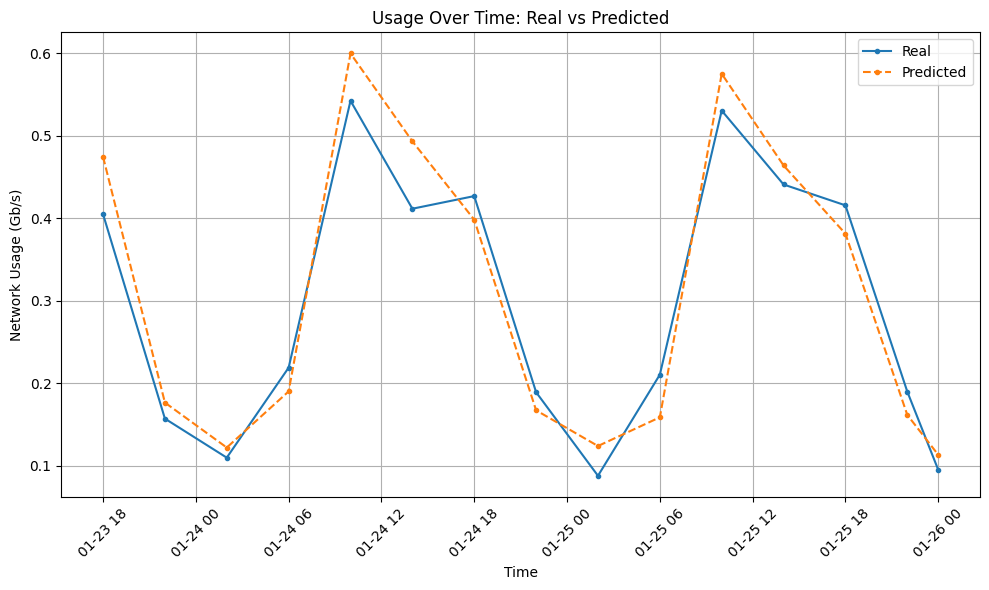

In [41]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-15:], y_test[-15:], label='Real', marker='.')
plt.plot(timestamps_test[-15:], predictions[-15:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

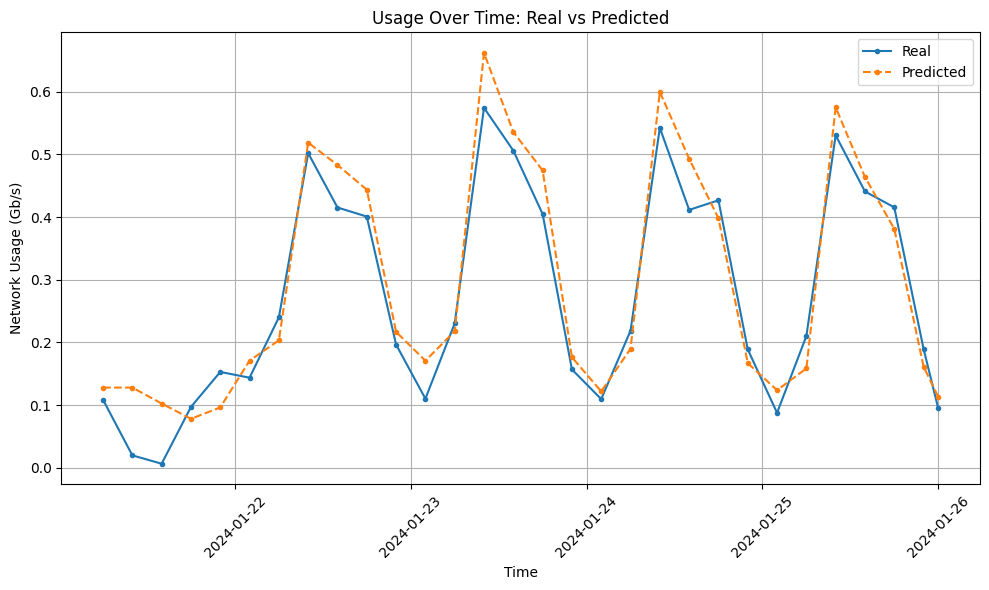

In [42]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-30:], y_test[-30:], label='Real', marker='.')
plt.plot(timestamps_test[-30:], predictions[-30:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

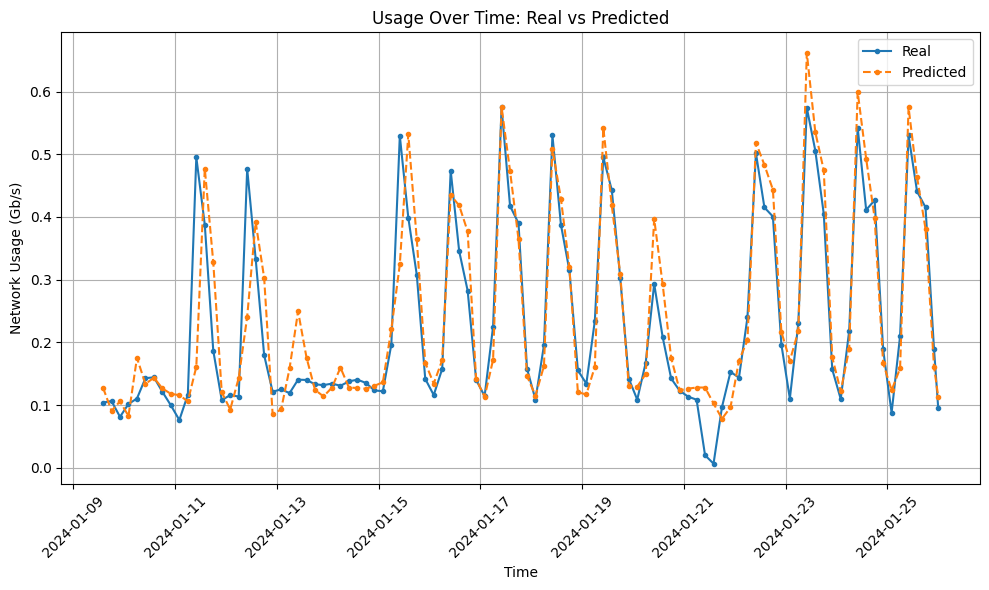

In [43]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

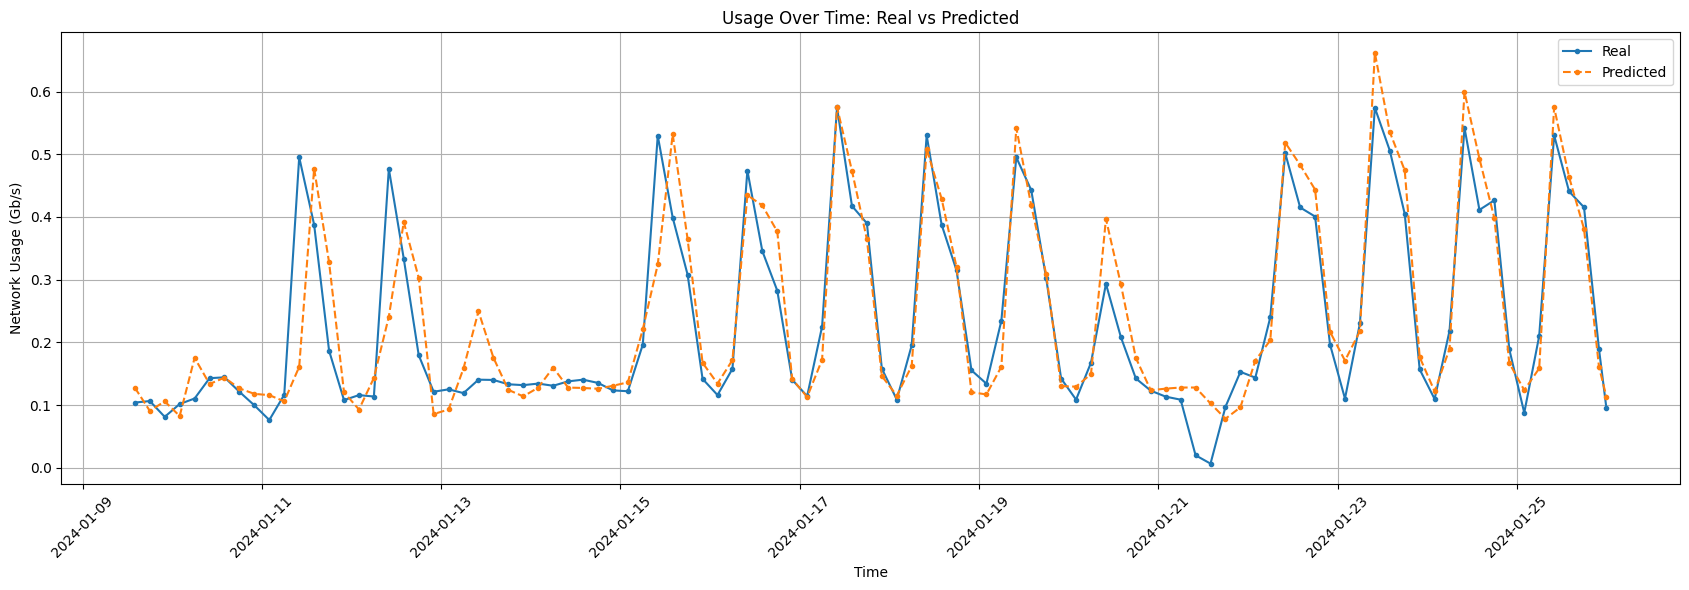

In [44]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(17, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

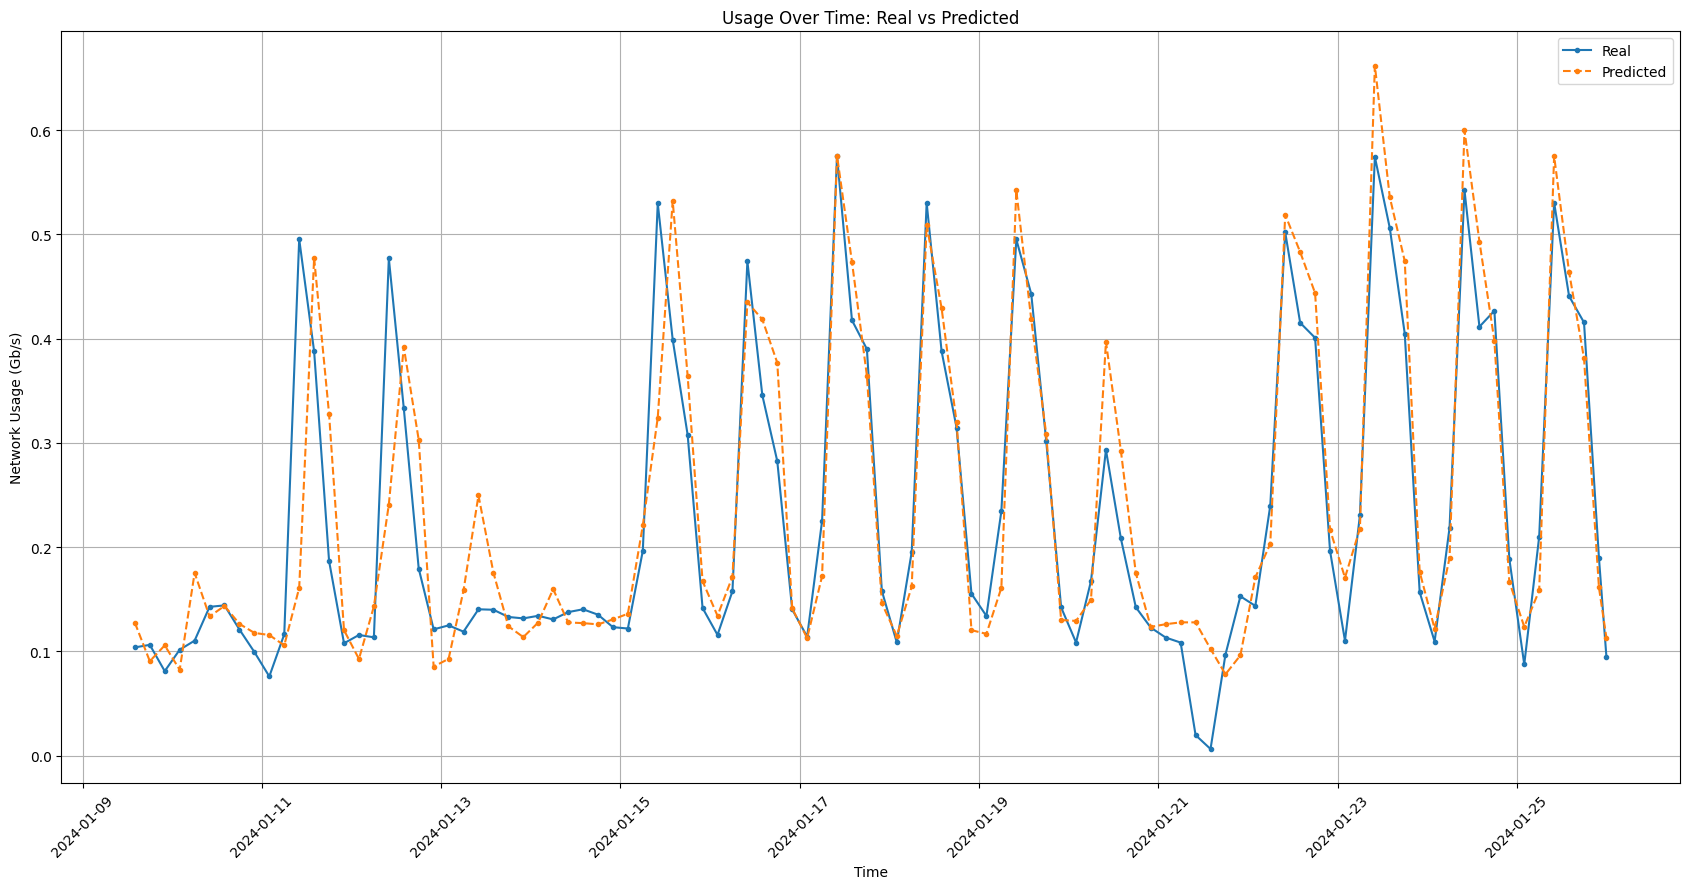

In [45]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(17, 9))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()

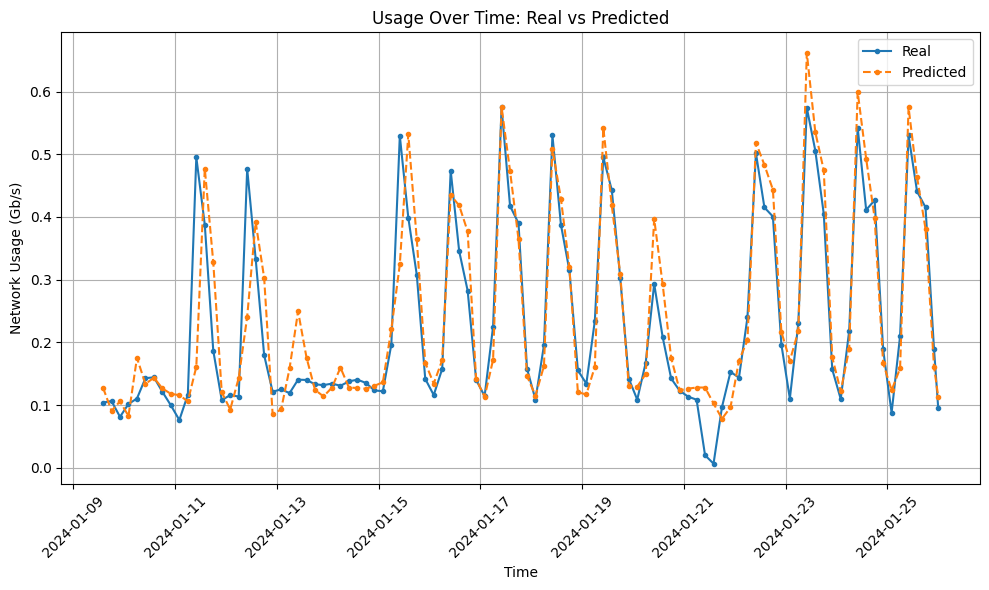

In [46]:
# Visualization of the Predictions vs Real Values
plt.figure(figsize=(10, 6))
plt.plot(timestamps_test[-100:], y_test[-100:], label='Real', marker='.')
plt.plot(timestamps_test[-100:], predictions[-100:], label='Predicted', linestyle='--', marker='.')
plt.title('Usage Over Time: Real vs Predicted')
plt.xlabel('Time')
plt.ylabel('Network Usage (Gb/s)')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45) # Rotate x-axis labels for better readability
plt.tight_layout() # Ensure the labels fit within the figure area
plt.show()